Upload untreated dataset for treatment:

In [1]:
from google.colab import files
uploaded = files.upload()

Saving scotch_review.csv to scotch_review.csv


Import all the required python libraries for EDA and ML Model Building:

In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

Convert the CSV file into a Pandas dataframe:

In [365]:
df = pd.read_csv('scotch_review.csv')

In [366]:
df.head(10)

,Unnamed: 0,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."
5,6,"Ardbeg Corryvreckan, 57.1%",Single Malt Scotch,96,85.00,$,"Powerful, muscular, well-textured, and invigor..."
6,7,"Gold Bowmore, 1964 vintage, 42.4%",Single Malt Scotch,96,6250.00,$,Deep gold color. Surprisingly lively on the no...
7,8,"Bowmore, 40 year old, 44.8%",Single Malt Scotch,96,11000.00,$,"Definitely showing its age, but not in a bad w..."
8,9,"The Dalmore, 50 year old, 52.8%",Single Malt Scotch,96,1500.00,$,The Dalmore is one of a handful of whiskies th...
9,10,"Glenfarclas Family Casks 1954 Cask #1260, 47.2%",Single Malt Scotch,96,3360,$,A rich amber color and elegantly oxidized note...


Drop columns that hold no computational value:

In [367]:
adf.drop(['Unnamed: 0','currency'], axis = 1, inplace = True)

In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          2247 non-null   object
 1   category      2247 non-null   object
 2   review.point  2247 non-null   int64 
 3   price         2247 non-null   object
 4   description   2247 non-null   object
dtypes: int64(1), object(4)
memory usage: 87.9+ KB


Check for any irregularities in the feature columns. Especially in numeric columns that are crucial for KMeans model development. 

In [369]:
pattern = r'[A-Za-z]'
df[df['price'].str.contains(pattern)]['price']

19      $15,000 or $60,000/set
95                  60,000/set
410                 60,000/set
576                   44/liter
1000                60,000/set
1215                60,000/set
Name: price, dtype: object

Impute values:

In [370]:
df.iloc[19,3] == 15000
df.price.replace(',', '', inplace = True, regex = True)
df.price =df.price.map(lambda x: x.split('/')[0])

Change data type of variables from object to numeric for streamlined computation:

In [371]:
df.price = pd.to_numeric(df.price, errors='coerce')

In [372]:
print(df.isnull().sum())
df.dropna(how='any', inplace=True)
print('------------------')
print(df.isnull().sum())
print('------------------')
print(df.info())

name            0
category        0
review.point    0
price           1
description     0
dtype: int64
------------------
name            0
category        0
review.point    0
price           0
description     0
dtype: int64
------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2246 entries, 0 to 2246
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2246 non-null   object 
 1   category      2246 non-null   object 
 2   review.point  2246 non-null   int64  
 3   price         2246 non-null   float64
 4   description   2246 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 105.3+ KB
None


Check and treat for duplicate data:

In [373]:
df.duplicated('name').sum()

24

In [374]:
df['agg_rating'] = df.groupby('name')['review.point'].transform('mean')
df['agg_price'] = df.groupby('name')['price'].transform('mean')

In [376]:
df[df.duplicated(subset = ['name'], keep = False)].sort_values('name').head(10)

,name,category,review.point,price,description,agg_rating,agg_price
983,"Aberlour 12 year old, 40%",Single Malt Scotch,87,55.0,Matured in a mix of bourbon and sherry casks. ...,85.5,49.5
1613,"Aberlour 12 year old, 40%",Single Malt Scotch,84,44.0,Somehow this 12 year old—a mix of sherry and A...,85.5,49.5
180,"Aberlour 18 year old, 43%",Single Malt Scotch,92,125.0,This has a significant proportion of sherry wo...,91.5,112.5
286,"Aberlour 18 year old, 43%",Single Malt Scotch,91,100.0,There was an Aberlour 18 on the market for a s...,91.5,112.5
594,"Arran 18 year old, 46%",Single Malt Scotch,89,100.0,Following the 2015 limited edition release of ...,89.0,110.0
593,"Arran 18 year old, 46%",Single Malt Scotch,89,120.0,This expression is the culmination of Arran’s ...,89.0,110.0
1442,"Benromach 15 year old, 43%",Single Malt Scotch,85,100.0,"A new member of the core range, this has a cin...",86.0,100.0
1009,"Benromach 15 year old, 43%",Single Malt Scotch,87,100.0,The aim with Benromach was always to rediscove...,86.0,100.0
303,"Bowmore, 18 year old, 43%",Single Malt Scotch,91,85.0,This replaces the 17 year old in the standard ...,91.0,85.0
352,"Bowmore, 18 year old, 43%",Single Malt Scotch,91,85.0,This replaces the 17 year old in the standard ...,91.0,85.0


In [377]:
df.drop_duplicates(subset = ['name'], keep='first', inplace = True)
df.drop(['price', 'review.point'], axis = 1, inplace = True)
df.rename(columns={"agg_rating": "rating", "agg_price": "price"}, inplace=True)
df = df[['name','category','rating','price','description']]

In [378]:
df.head()

,name,category,rating,price,description
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97.0,225.0,"Magnificently powerful and intense. Caramels, ..."
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97.0,4500.0,What impresses me most is how this whisky evol...
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97.0,13500.0,There have been some legendary Bowmores from t...
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96.0,325.0,With a name inspired by a 1926 Buster Keaton m...
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96.0,160.0,"Captivating, enticing, and wonderfully charmin..."


Creating new feature called alcohol content which will help us cluster similar whiskeys more accurately:

In [380]:
df[df.name.str.contains('%')].count()

name           2207
category       2207
rating         2207
price          2207
description    2207
dtype: int64

In [381]:
df['name'] = df['name'].str.replace(' ABV ', '')
df['alcohol'] = df['name'].str.extract(r"([\(\,\,\'\"\’\”\$] ? ?\d+(\.\d+)?%)")[0]
df['alcohol'] = df['alcohol'].str.replace("[^\d\.]", "").astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [382]:
df

,name,category,rating,price,description,alcohol
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97.0,225.0,"Magnificently powerful and intense. Caramels, ...",40.0
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97.0,4500.0,What impresses me most is how this whisky evol...,40.5
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97.0,13500.0,There have been some legendary Bowmores from t...,42.9
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96.0,325.0,With a name inspired by a 1926 Buster Keaton m...,53.4
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96.0,160.0,"Captivating, enticing, and wonderfully charmin...",40.0
...,...,...,...,...,...,...
2242,"Duncan Taylor (distilled at Cameronbridge), Ca...",Grain Scotch Whisky,72.0,125.0,"Its best attributes are vanilla, toasted cocon...",54.4
2243,Distillery Select 'Craiglodge' (distilled at L...,Single Malt Scotch,71.0,60.0,"Aged in a sherry cask, which adds sweet notes ...",45.0
2244,"Edradour Barolo Finish, 11 year old, 57.1%",Single Malt Scotch,70.0,80.0,"Earthy, fleshy notes with brooding grape notes...",57.1
2245,"Highland Park, Cask #7380, 1981 vintage, 25 ye...",Single Malt Scotch,70.0,225.0,"The sherry is very dominant and cloying, which...",55.0


In [386]:
df.alcohol.dropna(how = 'any', inplace = True)
df.alcohol.unique()

array([40.  , 40.5 , 42.9 , 53.4 , 57.1 , 42.4 , 44.8 , 52.8 , 47.2 ,
       50.8 , 45.4 , 44.  , 48.9 , 54.7 , 60.  , 49.9 , 54.2 , 40.7 ,
       55.7 , 50.  , 53.2 , 54.3 , 43.  , 46.  , 44.6 , 49.  , 54.4 ,
       51.2 , 45.7 , 50.5 , 52.  , 50.9 , 49.7 , 55.8 , 48.  , 58.1 ,
       53.  , 50.3 , 51.9 , 42.8 , 41.5 , 48.1 , 59.1 , 48.6 , 41.  ,
       44.9 , 45.  , 45.8 , 45.9 , 52.5 , 48.5 , 41.3 , 42.2 , 56.5 ,
       47.6 , 45.6 , 51.3 , 57.3 , 42.5 ,   nan, 46.9 , 41.7 , 51.8 ,
       61.6 , 50.4 , 43.7 , 52.9 , 42.  , 48.7 , 44.7 , 46.5 , 56.7 ,
       46.7 , 59.8 , 47.5 , 48.3 , 55.4 , 60.7 , 43.4 , 57.7 , 54.6 ,
       55.2 , 51.  , 45.1 , 57.9 , 54.9 , 52.1 , 43.5 , 48.8 , 48.2 ,
       56.6 , 53.1 , 46.8 , 57.4 , 50.6 , 52.3 , 49.1 , 63.5 , 51.5 ,
       42.3 , 46.1 , 56.  , 55.6 , 44.1 , 43.1 , 55.  , 47.1 , 60.8 ,
       57.6 , 51.6 , 54.1 , 58.6 , 53.9 , 52.7 , 54.  , 41.1 , 54.8 ,
       56.1 , 58.5 , 49.4 , 40.2 , 47.3 , 53.6 , 53.8 , 62.  , 53.7 ,
       49.2 , 46.3 ,

Engineer another variable from the name as age. This will also aid in the clustering purposes as this is an unsupervised learning excercise:


In [387]:
df['age'] = df.name.str.extract(r'(\d+) year')[0].astype(float)
df

,name,category,rating,price,description,alcohol,age
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97.0,225.0,"Magnificently powerful and intense. Caramels, ...",40.0,NaN
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97.0,4500.0,What impresses me most is how this whisky evol...,40.5,42.0
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97.0,13500.0,There have been some legendary Bowmores from t...,42.9,46.0
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96.0,325.0,With a name inspired by a 1926 Buster Keaton m...,53.4,NaN
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96.0,160.0,"Captivating, enticing, and wonderfully charmin...",40.0,NaN
...,...,...,...,...,...,...,...
2242,"Duncan Taylor (distilled at Cameronbridge), Ca...",Grain Scotch Whisky,72.0,125.0,"Its best attributes are vanilla, toasted cocon...",54.4,28.0
2243,Distillery Select 'Craiglodge' (distilled at L...,Single Malt Scotch,71.0,60.0,"Aged in a sherry cask, which adds sweet notes ...",45.0,8.0
2244,"Edradour Barolo Finish, 11 year old, 57.1%",Single Malt Scotch,70.0,80.0,"Earthy, fleshy notes with brooding grape notes...",57.1,11.0
2245,"Highland Park, Cask #7380, 1981 vintage, 25 ye...",Single Malt Scotch,70.0,225.0,"The sherry is very dominant and cloying, which...",55.0,25.0


In [389]:
df = df[['name','category','rating','price','alcohol','age','description']]
df

,name,category,rating,price,alcohol,age,description
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97.0,225.0,40.0,NaN,"Magnificently powerful and intense. Caramels, ..."
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97.0,4500.0,40.5,42.0,What impresses me most is how this whisky evol...
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97.0,13500.0,42.9,46.0,There have been some legendary Bowmores from t...
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96.0,325.0,53.4,NaN,With a name inspired by a 1926 Buster Keaton m...
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96.0,160.0,40.0,NaN,"Captivating, enticing, and wonderfully charmin..."
...,...,...,...,...,...,...,...
2242,"Duncan Taylor (distilled at Cameronbridge), Ca...",Grain Scotch Whisky,72.0,125.0,54.4,28.0,"Its best attributes are vanilla, toasted cocon..."
2243,Distillery Select 'Craiglodge' (distilled at L...,Single Malt Scotch,71.0,60.0,45.0,8.0,"Aged in a sherry cask, which adds sweet notes ..."
2244,"Edradour Barolo Finish, 11 year old, 57.1%",Single Malt Scotch,70.0,80.0,57.1,11.0,"Earthy, fleshy notes with brooding grape notes..."
2245,"Highland Park, Cask #7380, 1981 vintage, 25 ye...",Single Malt Scotch,70.0,225.0,55.0,25.0,"The sherry is very dominant and cloying, which..."


In [390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2222 entries, 0 to 2246
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         2222 non-null   object 
 1   category     2222 non-null   object 
 2   rating       2222 non-null   float64
 3   price        2222 non-null   float64
 4   alcohol      2205 non-null   float64
 5   age          1196 non-null   float64
 6   description  2222 non-null   object 
dtypes: float64(4), object(3)
memory usage: 138.9+ KB


Create a subdataset for clustering purposes and conduct EDA:

In [396]:
cal_df = df.iloc[:, 2:6]
cal_df

,rating,price,alcohol,age
0,97.0,225.0,40.0,NaN
1,97.0,4500.0,40.5,42.0
2,97.0,13500.0,42.9,46.0
3,96.0,325.0,53.4,NaN
4,96.0,160.0,40.0,NaN
...,...,...,...,...
2242,72.0,125.0,54.4,28.0
2243,71.0,60.0,45.0,8.0
2244,70.0,80.0,57.1,11.0
2245,70.0,225.0,55.0,25.0


In [397]:
cal_df.describe()

,rating,price,alcohol,age
count,2222.000000,2222.000000,2205.000000,1196.000000
mean,86.692619,642.515602,47.925937,20.985786
std,4.046366,4718.860869,5.877517,10.051531
min,63.000000,12.000000,40.000000,3.000000
25%,84.000000,70.000000,43.000000,13.000000
50%,87.000000,110.000000,46.000000,18.000000
75%,90.000000,200.000000,52.200000,26.000000
max,97.000000,157000.000000,67.400000,70.000000


It is interesting to note that price and rating do not have a strong positive relationship. This translate to not all expensive whiskeys being highly rated. There seems to be an absence of bias in the rating whiskeys.

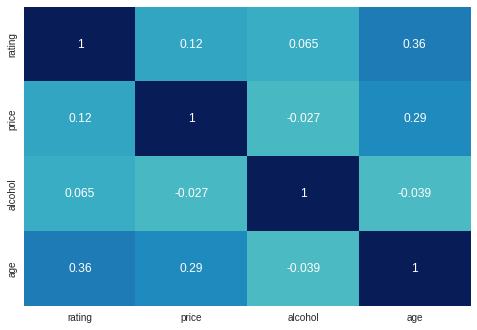

In [468]:
sns.heatmap(cal_df.corr(), cbar = False, annot = True, center = 0, cmap="YlGnBu")

In [399]:
def make_a_boxplot(df, title):
  with plt.style.context('fivethirtyeight'):
        df.boxplot(vert = False, figsize = (13,6), showfliers = False, showmeans = True, 
                 patch_artist=True, boxprops=dict(linestyle='-', linewidth=1.5),
                 flierprops=dict(linestyle='-', linewidth=1.5),
                 medianprops=dict(linestyle='-', linewidth=1.5),
                 whiskerprops=dict(linestyle='-', linewidth=1.5),
                 capprops=dict(linestyle='-', linewidth=1.5))
        plt.title(title, fontsize=16, fontweight='heavy')
        plt.show()

We can see from the boxplot below that age and alcohol have a right skew in their distribution as their mean sits to the right of the median whereas the rating boxplot shows characteristics of normally distributied with a slight left skew as the mean is to the left of the median.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


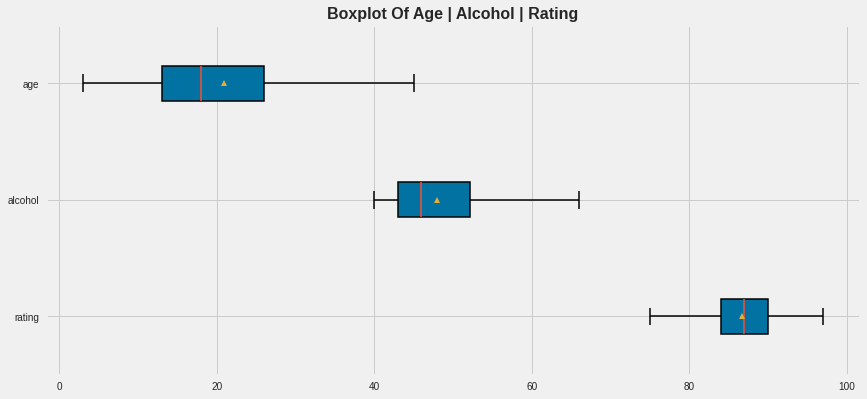

In [405]:
make_a_boxplot(cal_df[['rating','alcohol','age']], 'Boxplot Of Age | Alcohol | Rating')

The price variable has an extreme right skew as its mean lies towards to the boundaries of being an outlier.

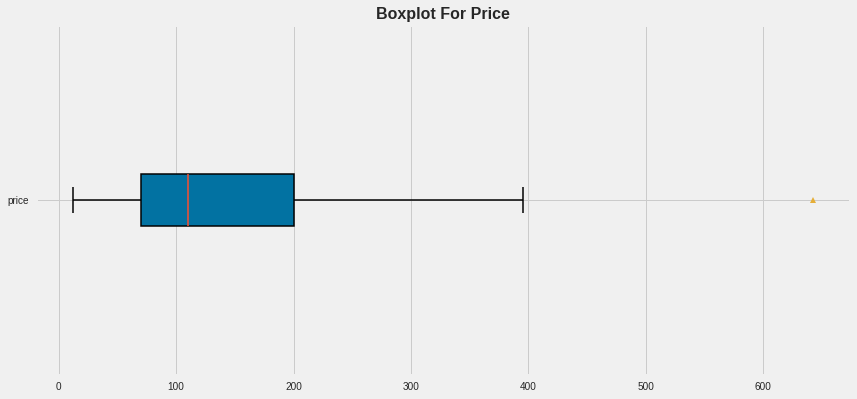

In [409]:
make_a_boxplot(cal_df[['price']], 'Boxplot For Price')

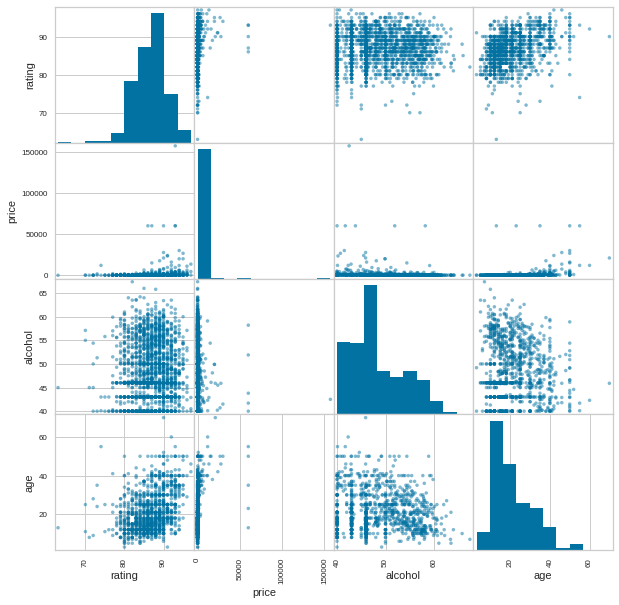

In [412]:
from pandas.plotting import scatter_matrix
scatter_matrix(cal_df, figsize = (10,10))
plt.show()

In [417]:
df.category.value_counts()

Single Malt Scotch            1797
Blended Scotch Whisky          209
Blended Malt Scotch Whisky     131
Single Grain Whisky             57
Grain Scotch Whisky             28
Name: category, dtype: int64

In [415]:
df.groupby('category').agg(np.mean)

,rating,price,alcohol,age
category,,,,
Blended Malt Scotch Whisky,87.660305,130.263359,46.716794,18.903226
Blended Scotch Whisky,87.234450,1012.904306,42.886603,20.360000
Grain Scotch Whisky,86.500000,272.428571,49.859259,32.222222
Single Grain Whisky,85.508772,219.578947,50.675439,29.229167
Single Malt Scotch,86.599610,655.962252,48.488933,20.514515


In [420]:
df_new = df.dropna().copy()
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1189 entries, 1 to 2246
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         1189 non-null   object 
 1   category     1189 non-null   object 
 2   rating       1189 non-null   float64
 3   price        1189 non-null   float64
 4   alcohol      1189 non-null   float64
 5   age          1189 non-null   float64
 6   description  1189 non-null   object 
dtypes: float64(4), object(3)
memory usage: 74.3+ KB


KMean clustering data:

In [423]:
data = df_new[['rating','alcohol','age']].copy()
data

,rating,alcohol,age
1,97.0,40.5,42.0
2,97.0,42.9,46.0
7,96.0,44.8,40.0
8,96.0,52.8,50.0
11,96.0,45.4,29.0
...,...,...,...
2242,72.0,54.4,28.0
2243,71.0,45.0,8.0
2244,70.0,57.1,11.0
2245,70.0,55.0,25.0


Initializing clustering process:

In [445]:
max_clusters = 11
perf = list()
for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=1)
    kmeans.fit(data)
    perf.append(kmeans.inertia_)

Testing performance over cluster counts:

In [446]:
performance = [list((i+1, perf[i])) for i in range(len(perf))]
print(tabulate(performance, headers = ['No. Clusters','Inertia']))

  No. Clusters    Inertia
--------------  ---------
             1   183713
             2    98663.7
             3    72141.9
             4    56594.7
             5    49048.5
             6    43442.1
             7    40092.7
             8    37155.8
             9    34635.7
            10    32301.9


Finding the optimal number of clusters:

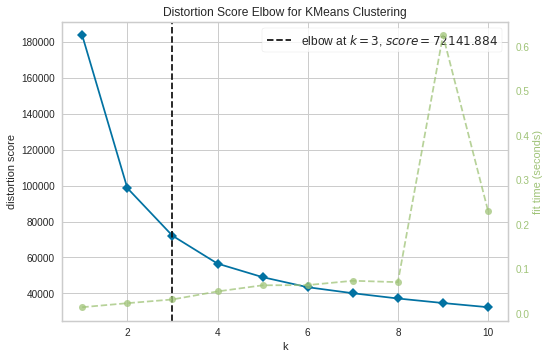

In [453]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(kmeans, k=(1,11), timings= True)
visualizer.fit(data)       
visualizer.show()    

In [455]:
kmeans = KMeans(n_clusters=3, init = 'k-means++', random_state = 1)
kmeans.fit_predict(data)
df_new['cluster'] = kmeans.labels_
data['cluster'] = kmeans.labels_

Cluster labelled 0 is the one with the highest counts of bottles.

In [458]:
data.cluster.value_counts()

0    547
1    365
2    277
Name: cluster, dtype: int64

Generating cluster visuals:

1. Cluster 0 which is the blue cluster has whiskey ranging from 3 to 26 in the age category and rating above 80
2. Cluster 1 is red with higher alcohol content and good rating but the whiskey is relatively young so bottles that are aged are rare to find.
3. Cluster 2 in green represents the highly rated aged whiskey in the collection. 

In [479]:
def cluster_see(df, num_clusters):
    with plt.style.context('fivethirtyeight'):
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        colors = ['r', 'g', 'b']
        plt.title('Cluster Visuals')

        for n in range(num_clusters):
            clustered_df = df[df['cluster'] == n]
            ax.scatter(clustered_df['age'], clustered_df['rating'], 
                       clustered_df['alcohol'], label=n, c=colors[n-1])
            ax.set_xlabel('Age Of Whiskey',fontsize=13)
            ax.set_ylabel('Rating Of Whiskey', fontsize=13)
            ax.set_zlabel('Alcohol Content', fontsize=13)
            ax.tick_params(axis="x", labelsize=10)
            ax.tick_params(axis="y", labelsize=10)
            ax.tick_params(axis="z", labelsize=10)
            ax.legend()
        plt.show()

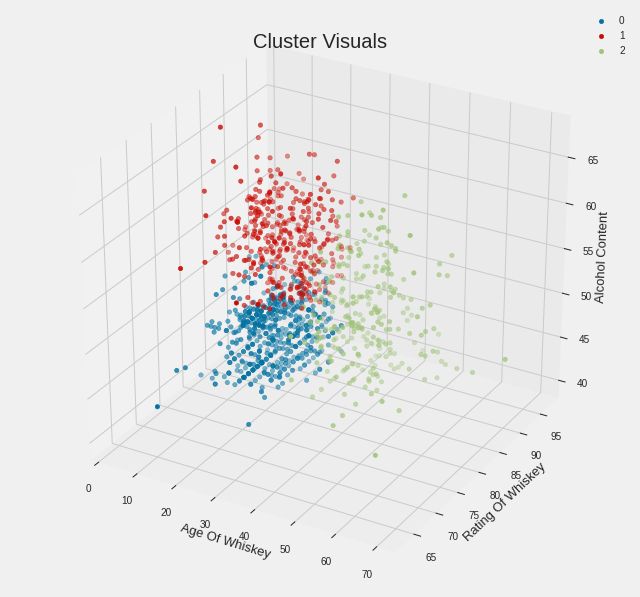

In [480]:
cluster_see(df_new, 3)

In [485]:
df_new[df_new.cluster == 0].value_counts('category')

category
Single Malt Scotch            442
Blended Scotch Whisky          79
Blended Malt Scotch Whisky     20
Single Grain Whisky             6
dtype: int64

In [486]:
df_new[df_new.cluster == 1].value_counts('category')

category
Single Malt Scotch            325
Single Grain Whisky            25
Grain Scotch Whisky             8
Blended Malt Scotch Whisky      6
Blended Scotch Whisky           1
dtype: int64

In [487]:
df_new[df_new.cluster == 2].value_counts('category')

category
Single Malt Scotch            225
Blended Scotch Whisky          20
Single Grain Whisky            17
Grain Scotch Whisky            10
Blended Malt Scotch Whisky      5
dtype: int64

In [497]:
def normalize_df(df_feat, df_no_feat):
    norm = MinMaxScaler().fit_transform(df_feat)
    scaled = pd.DataFrame(norm, index=df_feat.index, columns = df_feat.columns)
    return pd.concat([df_no_feat, scaled], axis=1)

In [490]:
df_feat = df_new[['rating', 'alcohol', 'age', 'price']]
df_no_feat = df_new.drop(['rating', 'alcohol', 'age', 'price'], axis=1)

In [491]:
df_norm = normalize_df(df_feat, df_no_feat)


In [495]:
df_norm

,name,category,description,cluster,rating,alcohol,age,price
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,What impresses me most is how this whisky evol...,2,1.000000,0.018248,0.582090,0.074800
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,There have been some legendary Bowmores from t...,2,1.000000,0.105839,0.641791,0.224832
7,"Bowmore, 40 year old, 44.8%",Single Malt Scotch,"Definitely showing its age, but not in a bad w...",2,0.970588,0.175182,0.552239,0.183156
8,"The Dalmore, 50 year old, 52.8%",Single Malt Scotch,The Dalmore is one of a handful of whiskies th...,2,0.970588,0.467153,0.701493,0.024789
11,"Macallan 1976 Vintage, 29 year old, cask #1135...",Single Malt Scotch,Classic sherry cask-aged Macallan. Antique amb...,2,0.970588,0.197080,0.388060,0.024789
...,...,...,...,...,...,...,...,...
2242,"Duncan Taylor (distilled at Cameronbridge), Ca...",Grain Scotch Whisky,"Its best attributes are vanilla, toasted cocon...",1,0.264706,0.525547,0.373134,0.001867
2243,Distillery Select 'Craiglodge' (distilled at L...,Single Malt Scotch,"Aged in a sherry cask, which adds sweet notes ...",0,0.235294,0.182482,0.074627,0.000784
2244,"Edradour Barolo Finish, 11 year old, 57.1%",Single Malt Scotch,"Earthy, fleshy notes with brooding grape notes...",1,0.205882,0.624088,0.119403,0.001117
2245,"Highland Park, Cask #7380, 1981 vintage, 25 ye...",Single Malt Scotch,"The sherry is very dominant and cloying, which...",1,0.205882,0.547445,0.328358,0.003534


In [496]:
import plotly.graph_objects as go
f1 = go.FigureWidget()

dims = list(df_norm.columns[4:])
dims.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(3):
    subset = df_norm[df_norm['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    f1.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Cluster " + str(i)
))
    
f1.update_layout(
        polar=layoutdict,
        showlegend=True,autosize=False,
        width=1000,
        height=800, font=dict(
        family="Verdana",
        size=20)
        )
f1.show()

Segmenting expensive scotch on price which gives us the top 25 most expensive whisky and then we sort these 25 whiskys around the rating for the whiskys.

In [592]:
bsw = df_new[df_new.category == 'Blended Scotch Whisky']
sms = df_new[df_new.category == 'Single Malt Scotch']
scotch = pd.concat([bsw, sms])
scotch_hp = scotch.sort_values('price', ascending=False).head(25)
scotch_hp.sort_values('rating', ascending = False).head(5)

,name,category,rating,price,alcohol,age,description,cluster
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97.0,13500.0,42.9,46.0,There have been some legendary Bowmores from t...,2
7,"Bowmore, 40 year old, 44.8%",Single Malt Scotch,96.0,11000.0,44.8,40.0,"Definitely showing its age, but not in a bad w...",2
20,"Bowmore 50 year old (distilled 1961), 40.7%",Single Malt Scotch,95.0,26650.0,40.7,50.0,"The whisky is sensational, a glorious mix of g...",2
48,"White Bowmore, 1964 vintage, 43 year old, 42.8%",Single Malt Scotch,94.0,6000.0,42.8,43.0,I like this Bowmore better than all the previo...,2
49,"Bowmore 1966 50 year old, 41.5%",Single Malt Scotch,94.0,30000.0,41.5,50.0,The third and most exclusive release in Bowmor...,2


Whiskey recommendation model based on cluster analysis model:

In [562]:
def recommend_me(name):
  rec = df_new[df_new.name.str.contains(name)].value_counts('cluster')
  clus = rec.index[0]
  return df_new[df_new.cluster == clus].sort_values('rating', ascending = False).head(10)  

In [572]:
name = input(str("Enter name of whiskey you wish to find an alternative for: "))
recommend_me(name)

Enter name of whiskey you wish to find an alternative for: Macallan


,name,category,rating,price,alcohol,age,description,cluster
16,"Chivas, 18 year old, 40%",Blended Scotch Whisky,95.0,70.0,40.0,18.0,An essay in balance on both the aroma and pala...,0
71,"The Macallan Fine Oak, 17 year old, 43%",Single Malt Scotch,94.0,120.0,43.0,17.0,Another of the Fine Oak series (aged in both b...,0
73,"The Antiquary, 21 year old, 43%",Blended Scotch Whisky,94.0,100.0,43.0,21.0,"Drier than the 12 year old (reviewed below), w...",0
42,Chivas Regal 18 year old Ultimate Cask Collect...,Blended Scotch Whisky,94.0,120.0,48.0,18.0,"An auld alliance renewed, this gorgeous whisky...",0
150,"Glen Moray 25 year old Port Cask Finish, 43%",Single Malt Scotch,93.0,300.0,43.0,25.0,Distilled in 1988 and finished for an unspecif...,0
87,"Black Bottle, 10 year old, 43%",Blended Scotch Whisky,93.0,34.0,43.0,10.0,Black Bottle is unique in that it combines sev...,0
89,"Dewar’s 25 year old, 40%",Blended Scotch Whisky,93.0,225.0,40.0,25.0,Aged for a quarter century and finished in Roy...,0
90,"Ardbeg, 10 year old, 46%",Single Malt Scotch,93.0,55.0,46.0,10.0,"Straw-gold color. On the nose, sweet toffee, c...",0
110,"GlenDronach, 15 year old, 46%",Single Malt Scotch,93.0,95.0,46.0,15.0,"Deeper, richer, more viscous, and more intrigu...",0
111,"GlenDronach 21 year old Parliament, 48%",Single Malt Scotch,93.0,262.0,48.0,21.0,"Part of the core range from GlenDronach, Parli...",0
